GBDT（Gradient Boosting Decision Tree，梯度提升决策树）是集成学习中**提升（Boosting）方法**的经典代表，通过组合多个弱学习器（通常是浅层决策树）构建强学习器，在分类、回归等任务中表现优异。以下从核心概念、原理、流程、细节及应用等方面详细解析。


### **一、核心概念铺垫**
在理解GBDT前，需先明确两个基础概念：


#### **1. 集成学习与提升（Boosting）**
集成学习通过组合多个模型（弱学习器）的预测结果提升性能，核心思想是“**三个臭皮匠顶个诸葛亮**”。根据弱学习器的组合方式，可分为两类：
- **Bagging**：并行训练多个独立的弱学习器（如随机森林），通过投票/平均输出结果，降低方差（抗过拟合）。
- **Boosting**：串行训练弱学习器，每个新学习器专注于纠正前序模型的错误（通过调整样本权重或学习方向），降低偏差（提升精度）。

GBDT属于**Boosting**，其弱学习器为**浅层决策树**（通常深度1-5，称为“树桩”或“弱树”）。


#### **2. 梯度下降与损失函数**
GBDT的“梯度”源于**梯度下降思想**：通过最小化损失函数（衡量预测值与真实值的差异）优化模型。损失函数的“负梯度”指示了模型参数的更新方向（即“往损失减小最快的方向调整”）。


### **二、GBDT的核心思想**
GBDT的核心是“**用梯度下降的方式，让新的弱学习器拟合前序模型的‘错误’**”，具体可拆解为：
1. 初始模型：用一个简单模型（如常数）作为起点。
2. 迭代优化：每次训练一个新的弱学习器，目标是**拟合当前模型的“损失梯度”**（即“错误的方向”），通过逐步纠正错误提升性能。
3. 最终模型：将所有弱学习器的输出加权求和，得到强学习器。


### **三、GBDT的详细流程**
假设任务为“预测样本标签$y$”，输入特征为$x$，最终模型为$F(x)$，总迭代次数为$M$（即$M$个弱学习器），流程如下：


#### **1. 初始化模型**
初始模型$F_0(x)$是一个简单的常数（或基准值），目的是最小化初始损失。
例如，对于回归问题（平方损失），初始模型为所有样本标签的均值：
$$F_0(x) = \arg\min_\gamma \sum_{i=1}^N L(y_i, \gamma)$$
（$L$为损失函数，$N$为样本数，$\gamma$为常数）


#### **2. 迭代生成弱学习器（核心步骤）**
每次迭代训练一个新的弱学习器（决策树），逐步优化模型。设第$m$次迭代的模型为$F_m(x)$，前序模型为$F_{m-1}(x)$，步骤如下：


##### **步骤1：计算“损失梯度”（残差的近似）**
损失函数$L(y_i, F_{m-1}(x_i))$衡量当前模型对样本$i$的预测误差。为了让新模型$F_m(x)$降低损失，需找到“损失减小最快的方向”——即损失函数对$F_{m-1}(x_i)$的**负梯度**（可理解为“当前模型的错误方向”）。

定义样本$i$的“伪残差”（负梯度）为：
$$r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F=F_{m-1}}$$

- 若为**回归任务（平方损失$L(y, \hat{y}) = \frac{1}{2}(y-\hat{y})^2$）**，负梯度为：
  $$r_{im} = y_i - F_{m-1}(x_i)$$
  即“真实值 - 前序模型预测值”，等价于“残差”。
- 若为**二分类任务（对数损失$L(y, \hat{y}) = -y\log p - (1-y)\log(1-p)$，$p$为预测概率）**，负梯度为：
  $$r_{im} = y_i - p_{i,m-1}$$
  （$p_{i,m-1}$为前序模型对样本$i$的预测概率）


##### **步骤2：用决策树拟合“伪残差”**
用**CART树（分类回归树）** 拟合所有样本的伪残差$r_{im}$，得到第$m$个弱学习器$h_m(x)$。

GBDT中的决策树通常是**浅层树（深度1-5）**，原因是：弱学习器需“弱”（避免过拟合），多个弱学习器的组合才能体现集成优势。若用深树（强学习器），单棵树即可拟合数据，集成无意义。


##### **步骤3：计算“步长”（学习率）**
新学习器$h_m(x)$的输出需乘以一个“步长”$\alpha_m$（也叫学习率），控制每次迭代的更新幅度（防止过拟合）。$\alpha_m$通过**最小化损失函数**确定：

对于决策树$h_m(x)$的每个叶节点区域$R_{mj}$（共$J$个），该区域内样本的最优步长为：
$$\alpha_{mj} = \arg\min_\alpha \sum_{x_i \in R_{mj}} L(y_i, F_{m-1}(x_i) + \alpha)$$

实际应用中，为简化计算，常将步长设为固定值（如0.1），通过增加迭代次数$M$补偿精度。


##### **步骤4：更新模型**
将新学习器的输出（加权后）加入当前模型：
$$F_m(x) = F_{m-1}(x) + \sum_{j=1}^J \alpha_{mj} \cdot I(x \in R_{mj})$$
（$I$为指示函数：$x$属于$R_{mj}$时为1，否则为0）


#### **3. 最终模型**
经过$M$次迭代后，最终模型为所有弱学习器的加权和：
$$F_M(x) = F_0(x) + \sum_{m=1}^M \sum_{j=1}^J \alpha_{mj} \cdot I(x \in R_{mj})$$


### **四、关键细节解析**
#### **1. 损失函数的选择**
GBDT的通用性源于可适配不同损失函数，常见场景如下：

| 任务类型 | 常用损失函数 | 负梯度（伪残差） |
|----------|--------------|------------------|
| 回归     | 平方损失（$L_2$） | $y - \hat{y}$（残差） |
| 回归     | 绝对损失（$L_1$） | $\text{sign}(y - \hat{y})$（符号函数） |
| 二分类   | 对数损失（交叉熵） | $y - p$（$p$为预测概率） |
| 多分类   | 多类交叉熵 | 类别指示变量 - 预测概率 |


#### **2. 与AdaBoost的区别**
两者同属Boosting，但核心逻辑不同：
- **AdaBoost**：通过调整样本权重（错分样本权重升高）让新学习器聚焦错误，损失函数固定为指数损失。
- **GBDT**：通过梯度下降优化任意损失函数，新学习器拟合损失函数的负梯度（而非调整样本权重），适用范围更广。


#### **3. 防止过拟合的策略**
GBDT易因迭代次数过多或树过深导致过拟合，常用手段：
- 限制树深度（如最大深度3-5）；
- 减小学习率（如0.01-0.1），同时增加迭代次数；
- 加入正则化（如叶节点数量限制、学习器输出的$L_2$正则）；
- 子采样（每次迭代随机选部分样本训练，类似随机森林）。


### **五、优缺点与应用场景**
#### **优点**
- 预测精度高：在结构化数据（表格数据）上表现优异，常作为竞赛 baseline；
- 适配性强：支持分类、回归、排序等任务，对特征类型（连续/离散）不敏感；
- 可解释性：能输出特征重要性（通过特征在树中的分裂次数或贡献度衡量）；
- 无需特征缩放：决策树本身对特征尺度不敏感，省去标准化步骤。


#### **缺点**
- 训练效率低：串行迭代（后一棵树依赖前一棵），难以并行加速；
- 对高维稀疏数据不友好：如文本数据（词袋特征），效果不如线性模型或深度学习；
- 调参复杂：需优化树深度、学习率、迭代次数等多个参数。


#### **应用场景**
- 金融：信用评分、风险预测（如贷款违约概率）；
- 推荐系统：点击率（CTR）、转化率（CVR）预测；
- 电商：用户流失预警、销量预测；
- 医疗：疾病风险评估（如糖尿病发病概率）。


### **六、变种与优化**
GBDT的经典变种通过工程优化提升效率，代表有：
- **XGBoost**：加入二阶导数优化损失计算，支持并行分裂节点，添加正则化项，训练速度和精度均有提升；
- **LightGBM**：采用 histogram 算法加速特征分裂，支持带深度限制的叶子生长策略，进一步提升效率。


### **总结**
GBDT的核心是“**用梯度下降思想，让多个浅层决策树逐步纠正错误**”：通过拟合损失函数的负梯度（伪残差），将弱学习器“串联”成强学习器。其优势在于精度高、适配性强，是结构化数据任务的首选模型之一，理解其原理对掌握集成学习至关重要。


#### 代码实例（2个独立Python文件）

##### 1. 简洁版：sklearn实现GBDT（分类与回归）  

=== GBDT分类评估 ===
准确率：0.9474

分类报告：
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        64
           1       0.95      0.97      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



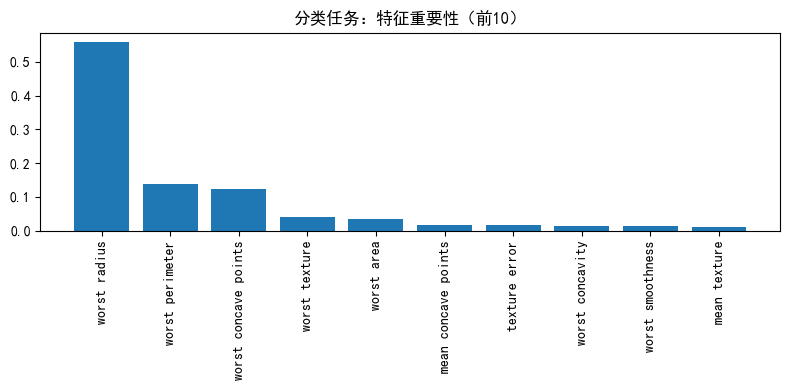

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_squared_error, r2_score
)
from sklearn.preprocessing import StandardScaler

# 1. GBDT分类（乳腺癌数据集）
def gbdt_classification():
    # 加载数据
    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 标准化（GBDT对特征尺度不敏感，但标准化不影响结果）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 训练GBDT分类器
    gbdt_clf = GradientBoostingClassifier(
        n_estimators=100,    # 100棵树
        learning_rate=0.1,   # 学习率
        max_depth=3,         # 树深3（控制复杂度）
        random_state=42
    )
    gbdt_clf.fit(X_train_scaled, y_train)

    # 评估
    y_pred = gbdt_clf.predict(X_test_scaled)
    print("=== GBDT分类评估 ===")
    print(f"准确率：{accuracy_score(y_test, y_pred):.4f}")
    print("\n分类报告：")
    print(classification_report(y_test, y_pred))

    # 特征重要性可视化
    importances = gbdt_clf.feature_importances_  # feature_importances_ 主要存在于基于树的模型中
    indices = np.argsort(importances)[::-1][:10]  # 前10特征
    feature_names = np.array(data.feature_names)

    plt.figure(figsize=(8, 4))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), feature_names[indices], rotation=90)
    plt.title("分类任务：特征重要性（前10）")
    plt.tight_layout()
    plt.show()

gbdt_classification()


=== GBDT回归评估 ===
MSE：0.2830
R²：0.7844


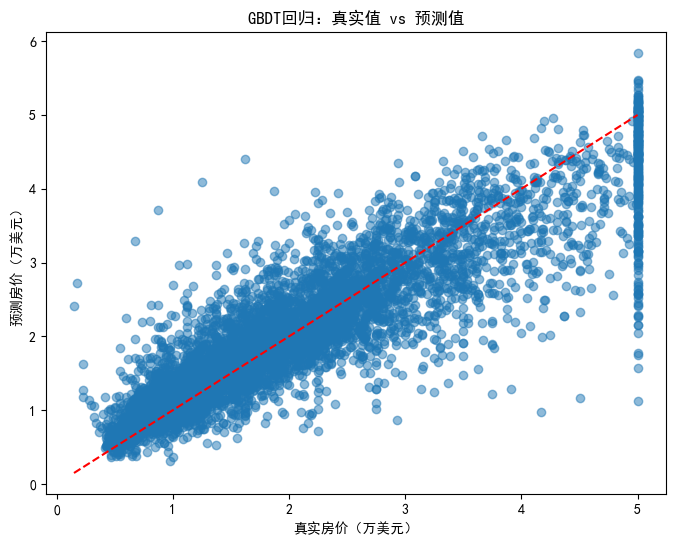

In [7]:
# 2. GBDT回归（波士顿房价数据集，替换为加利福尼亚房价）
def gbdt_regression():
    # 加载数据
    data = datasets.fetch_california_housing()
    X, y = data.data, data.target

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 训练GBDT回归器
    gbdt_reg = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,  # 随机梯度提升（80%样本）
        random_state=42
    )
    gbdt_reg.fit(X_train, y_train)

    # 评估
    y_pred = gbdt_reg.predict(X_test)
    print("\n=== GBDT回归评估 ===")
    print(f"MSE：{mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²：{r2_score(y_test, y_pred):.4f}")

    # 真实值 vs 预测值可视化
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 理想线
    plt.xlabel("真实房价（万美元）")
    plt.ylabel("预测房价（万美元）")
    plt.title("GBDT回归：真实值 vs 预测值")
    plt.show()

gbdt_regression()

##### 2. 全面版：sklearn实现（参数调优+模型对比）  

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import (load_iris, fetch_california_housing)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor)
from sklearn.metrics import (accuracy_score, classification_report, mean_squared_error, r2_score)

# 1. 鸢尾花分类
def gbdt_classification_tuning():
    # 加载分类数据集（鸢尾花数据集）
    data = load_iris()
    X, y = data.data, data.target
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # 数据标准化（使用同一个StandardScaler实例）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # 拟合并转换训练数据
    X_test_scaled = scaler.transform(X_test)        # 使用相同的scaler转换测试数据
    
    # 定义参数网格（精简范围）
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
    
    # 初始化GBDT分类器
    gbdt = GradientBoostingClassifier(random_state=42)
    
    # 网格搜索
    grid_search = GridSearchCV(
        estimator=gbdt,
        param_grid=param_grid,
        cv=3,
        # n_jobs=-1 表示使用计算机的所有可用处理器核心并行进行网格搜索，
        n_jobs=-1,
        # scoring='accuracy' 表示在网格搜索过程中，使用准确率（Accuracy）作为评估指标
        scoring='accuracy',
        # verbose=1 表示在网格搜索过程中输出详细程度为 1 的日志信息，
        verbose=1

    )
    
    # 训练模型
    grid_search.fit(X_train_scaled, y_train)
    
    # 输出最佳参数
    print("最佳分类参数:", grid_search.best_params_)
    
    # 最佳模型预测
    y_pred = grid_search.predict(X_test_scaled)
    
    # 评估结果
    print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))

print("=== GBDT分类参数调优 ===")
gbdt_classification_tuning()

=== GBDT分类参数调优 ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
最佳分类参数: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
测试集准确率: 0.9333

分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.93      0.90        15
           2       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



In [ ]:
# 2. 波士顿房价回归
def gbdt_regression_tuning():
    # 加载回归数据集（加州房价数据集）
    data = fetch_california_housing()
    X, y = data.data, data.target
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # 数据标准化（使用同一个StandardScaler实例）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # 拟合并转换训练数据
    X_test_scaled = scaler.transform(X_test)        # 使用相同的scaler转换测试数据
    
    # 定义参数网格（精简范围）
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
    
    # 初始化GBDT回归器
    gbdt = GradientBoostingRegressor(random_state=42)
    
    # 网格搜索
    grid_search = GridSearchCV(
        estimator=gbdt,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    
    # 训练模型
    grid_search.fit(X_train_scaled, y_train)
    
    # 输出最佳参数
    print("最佳回归参数:", grid_search.best_params_)
    
    # 最佳模型预测
    y_pred = grid_search.predict(X_test_scaled)
    
    # 评估结果
    print(f"测试集MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"测试集R²: {r2_score(y_test, y_pred):.4f}")

print("\n=== GBDT回归参数调优 ===")
gbdt_regression_tuning()

### 总结  
GBDT是工业界和学术界公认的高性能算法，尤其在结构化数据上表现卓越。实践中需重点关注以下几点：  

1.** 超参数平衡 **：`learning_rate`和`n_estimators`需协同调整（小学习率通常需要更多树），`max_depth`控制树复杂度（建议3-5）；  
2.** 正则化策略 **：通过`subsample`（样本抽样）和`subsample_features`（特征抽样）实现随机梯度提升，有效降低过拟合风险；  
3.** 训练效率 **：相比随机森林，GBDT训练速度较慢，可通过减少树数量、增大学习率或使用-lightGBM/XGBoost等优化实现加速；  
4.** 适用场景**：优先用于结构化数据（表格数据），避免直接用于高维稀疏数据（如文本）。  